<a href="https://colab.research.google.com/github/VasanthPrakasam/DL-P5---Building_a_Brain_Tumor_Detector_using_MRI_Images/blob/main/Project_4_Brain_Tumor_MRI_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Finding the MRI brain tumor detection dataset**
https://www.kaggle.com/datasets/ivasanthp/brain-tumor-mri-image-classification/data?select=Tumour-20250908T112353Z-1-001

# **Import packages**

In [18]:
!pip install tensorflow

In [17]:
!pip install keras

In [ ]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,TensorBoard,LambdaCallback
from keras.layers import Input,Dropout, Dense,GlobalAveragePooling2D
from keras.models import Sequential,Model
from keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from sklearn.utils import shuffle
import matplotlib.image as mpimg
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from tensorflow import keras
import tensorflow as tf
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import numpy as np
import itertools
import datetime
import shutil
import torch
import glob

import cv2
import os
import io

from keras import models, layers

In [ ]:
print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)
print("PyTorch version:", torch.__version__)
print("All imports successful!")

TensorFlow version: 2.19.0
Keras version: 3.10.0
PyTorch version: 2.8.0+cu126
All imports successful!


# **Data Preperation**



    Load all training and testing data

    Pre-processing images (apply opencv functions : bilateralFilter,applyColorMap,resize)

    Append images and labels into Python list

    Convert lists into numpy array and normalize images with devide by 255

    One Hot Encoding on the labels

    Dividing the dataset into Training and Validation sets


In [ ]:
import os
import zipfile
from google.colab import drive

# 1. Mount Google Drive
drive.mount('/content/Vasanth_P')

# 2. Specify paths
drive_path = '/content/Vasanth_P/MyDrive/Project_4_Brain_Tumor_MRI_Image_Classification'  # Adjust if your file is in a different folder
zip_file_path = os.path.join(drive_path, 'Tumour-20250908T112353Z-1-001.zip')  # Change to your zip file name
extract_path = '/content/Vasanth_P/MyDrive/Project_4_Brain_Tumor_MRI_Image_Classification/dataset'  # Where to extract files

# 3. Create extraction directory if it doesn't exist
os.makedirs(extract_path, exist_ok=True)

# 4. Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
    print(f"Extracted files to: {extract_path}")

Mounted at /content/Vasanth_P
Extracted files to: /content/Vasanth_P/MyDrive/Project_4_Brain_Tumor_MRI_Image_Classification/dataset


In [ ]:
# 5. Verify the extracted folders
dataset_path = os.path.join(extract_path, '/content/Vasanth_P/MyDrive/Project_4_Brain_Tumor_MRI_Image_Classification/dataset')  # Change to your extracted folder name
train_dir = os.path.join(dataset_path, '/content/Vasanth_P/MyDrive/Project_4_Brain_Tumor_MRI_Image_Classification/dataset/Tumour/train')
val_dir = os.path.join(dataset_path, '/content/Vasanth_P/MyDrive/Project_4_Brain_Tumor_MRI_Image_Classification/dataset/Tumour/valid')
test_dir = os.path.join(dataset_path, '/content/Vasanth_P/MyDrive/Project_4_Brain_Tumor_MRI_Image_Classification/dataset/Tumour/test')

print("\nVerifying directories:")
print("Train exists:", os.path.exists(train_dir))
print("Validation exists:", os.path.exists(val_dir))
print("Test exists:", os.path.exists(test_dir))

# 6. Sample directory listing (optional)
if os.path.exists(train_dir):
    print("\nSample train directory contents:")
    print(os.listdir(train_dir)[:5])  # Show first 5 items


Verifying directories:
Train exists: True
Validation exists: True
Test exists: True

Sample train directory contents:
['_classes.csv', 'no_tumor', 'pituitary', 'meningioma', 'glioma']


In [ ]:
## Data Preprocessing and Augmentation

# Training data generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0, 1]

    # Data augmentation parameters
    rotation_range=20,  # Random rotation between -20 and +20 degrees
    width_shift_range=0.2,  # Random horizontal shift by ±20% of width
    height_shift_range=0.2,  # Random vertical shift by ±20% of height
    zoom_range=0.2,  # Random zoom between 80% and 120%
    horizontal_flip=True,  # Random horizontal flipping
    vertical_flip=False,  # No vertical flipping (can enable if appropriate)
    fill_mode='nearest'  # Strategy for filling in newly created pixels
)

# Validation and test generators (only rescaling, no augmentation)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Set image size and batch size
img_width, img_height = 224, 224  # Adjust as needed
batch_size = 32  # Adjust as needed

# Create data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'  # or 'binary' if you have two classes
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Important for evaluating the test set
)


Found 1695 images belonging to 4 classes.
Found 502 images belonging to 4 classes.
Found 246 images belonging to 4 classes.


In [ ]:
# Get class names and number of classes
class_names = list(train_generator.class_indices.keys())
num_classes = len(class_names)
print(f"Class names: {class_names}")
print(f"Number of classes: {num_classes}")

Class names: ['glioma', 'meningioma', 'no_tumor', 'pituitary']
Number of classes: 4


# **Build a simple CNN model**

In [ ]:
# Build a simple CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy',
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall')])

# Model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,476 (42.61 MB)

 Trainable params: 11,169,476 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
epochs = 15
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 43s 692ms/step - accuracy: 0.4097 - loss: 1.4458 - precision: 0.4646 - recall: 0.1057 - val_accuracy: 0.6583 - val_loss: 0.9680 - val_precision: 0.7798 - val_recall: 0.2729
Epoch 2/15
 1/52 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - accuracy: 0.5938 - loss: 0.9589 - precision: 0.8889 - recall: 0.2500

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.5938 - loss: 0.9589 - precision: 0.8889 - recall: 0.2500 - val_accuracy: 0.6750 - val_loss: 0.9840 - val_precision: 0.7435 - val_recall: 0.2958
Epoch 3/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 31s 589ms/step - accuracy: 0.5692 - loss: 1.0326 - precision: 0.7181 - recall: 0.3009 - val_accuracy: 0.5604 - val_loss: 1.0821 - val_precision: 0.6604 - val_recall: 0.4417
Epoch 4/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.6129 - loss: 0.8850 - precision: 0.7500 - recall: 0.4839 - val_accuracy: 0.5167 - val_loss: 1.2446 - val_precision: 0.5655 - val_recall: 0.3958
Epoch 5/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 30s 583ms/step - accuracy: 0.6725 - loss: 0.8348 - precision: 0.7505 - recall: 0.5452 - val_accuracy: 0.4750 - val_loss: 1.1970 - val_precision: 0.5579 - val_recall: 0.3917
Epoch 6/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - accuracy: 0.6250 - loss: 0.7846 - precision: 0.7826 - recall: 0.5625 - val_accuracy: 0.5604 - val_loss: 1.0493 - val_p

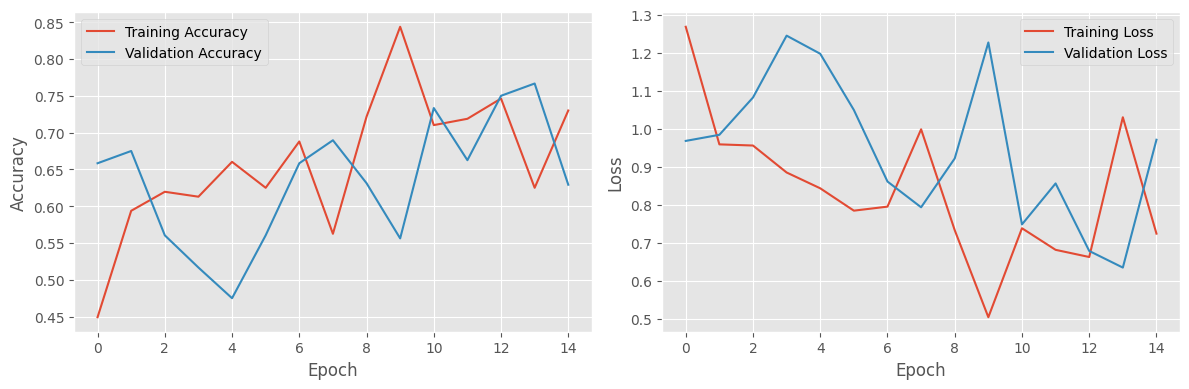

In [ ]:
# Plot training history
def plot_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)

In [ ]:
# Evaluate on test set
test_loss, test_acc, test_precision, test_recall = model.evaluate(test_generator)
print(f'\nTest accuracy: {test_acc:.4f}')
print(f'Test precision: {test_precision:.4f}')
print(f'Test recall: {test_recall:.4f}')

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 379ms/step - accuracy: 0.5513 - loss: 1.2409 - precision: 0.6835 - recall: 0.5001

Test accuracy: 0.6260
Test precision: 0.7157
Test recall: 0.5732


In [ ]:
# Get true classes
true_classes = test_generator.classes

In [ ]:
# Get predictions on the test set
predictions = model.predict(test_generator)

# Get predicted classes
predicted_classes = np.argmax(predictions, axis=1)

# Classification report
print('\nClassification Report:')
print(classification_report(true_classes, predicted_classes, target_names=class_names))

# Confusion matrix
conf_mat = confusion_matrix(true_classes, predicted_classes)
print('\nConfusion Matrix:')
print(conf_mat)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 187ms/step

Classification Report:
              precision    recall  f1-score   support

      glioma       0.89      0.49      0.63        80
  meningioma       0.68      0.51      0.58        63
    no_tumor       0.43      0.94      0.59        49
   pituitary       0.77      0.69      0.73        54

    accuracy                           0.63       246
   macro avg       0.69      0.65      0.63       246
weighted avg       0.72      0.63      0.63       246


Confusion Matrix:
[[39 11 22  8]
 [ 4 32 24  3]
 [ 1  2 46  0]
 [ 0  2 15 37]]


# **VGG16 Evaluation**

In [20]:
#Setup and Data Preparation
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import (VGG16, ResNet50, MobileNet,
                                          InceptionV3, EfficientNetB0)
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

dataset_path = os.path.join(extract_path, '/content/Vasanth_P/MyDrive/Project_4_Brain_Tumor_MRI_Image_Classification/dataset')  # Change to your extracted folder name

train_dir = os.path.join(dataset_path, '/content/Vasanth_P/MyDrive/Project_4_Brain_Tumor_MRI_Image_Classification/dataset/Tumour/train')
val_dir = os.path.join(dataset_path, '/content/Vasanth_P/MyDrive/Project_4_Brain_Tumor_MRI_Image_Classification/dataset/Tumour/valid')
test_dir = os.path.join(dataset_path, '/content/Vasanth_P/MyDrive/Project_4_Brain_Tumor_MRI_Image_Classification/dataset/Tumour/test')

# Data generators setup
img_size = (224, 224)
batch_size = 32

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    horizontal_flip=True
)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

num_classes = len(train_generator.class_indices)
class_names = list(train_generator.class_indices.keys())

# Results storage
model_comparison = []

Found 1695 images belonging to 4 classes.
Found 502 images belonging to 4 classes.


In [21]:
def evaluate_vgg16():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False

    model = tf.keras.Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(0.001),
                 loss='categorical_crossentropy',
                 metrics=['accuracy',
                         tf.keras.metrics.Precision(name='precision'),
                         tf.keras.metrics.Recall(name='recall')])

    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=10,
        callbacks=[EarlyStopping(patience=3)]
    )

    return model, history


In [22]:
vgg_model, vgg_history = evaluate_vgg16()
model_comparison.append({
    'Model': 'VGG16',
    'Val Accuracy': max(vgg_history.history['val_accuracy']),
    'Val Precision': max(vgg_history.history['val_precision']),
    'Val Recall': max(vgg_history.history['val_recall']),
    'Parameters': f"{vgg_model.count_params():,}",
    'Inference Time': 'Medium',
    'Best For': 'Medium-sized datasets'
})

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.2579 - loss: 1.5565 - precision: 0.2390 - recall: 0.0605 - val_accuracy: 0.5578 - val_loss: 1.2336 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 619ms/step - accuracy: 0.4689 - loss: 1.2394 - precision: 0.7832 - recall: 0.0617 - val_accuracy: 0.5996 - val_loss: 1.1162 - val_precision: 0.8977 - val_recall: 0.1574
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 617ms/step - accuracy: 0.6024 - loss: 1.0915 - precision: 0.8259 - recall: 0.1781 - val_accuracy: 0.6594 - val_loss: 1.0179 - val_precision: 0.8870 - val_recall: 0.2032
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 36s 681ms/step - accuracy: 0.6522 - loss: 1.0086 - precision: 0.8352 - recall: 0.2318 - val_accuracy: 0.6733 - val_loss: 0.9555 - val_precision: 0.7946 - val_recall: 0.2928
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 613ms/step - accuracy: 0.6523 - loss: 0.9709 - precision: 0.7814 - recall: 0.2879 - val_accuracy: 0.6693 - va

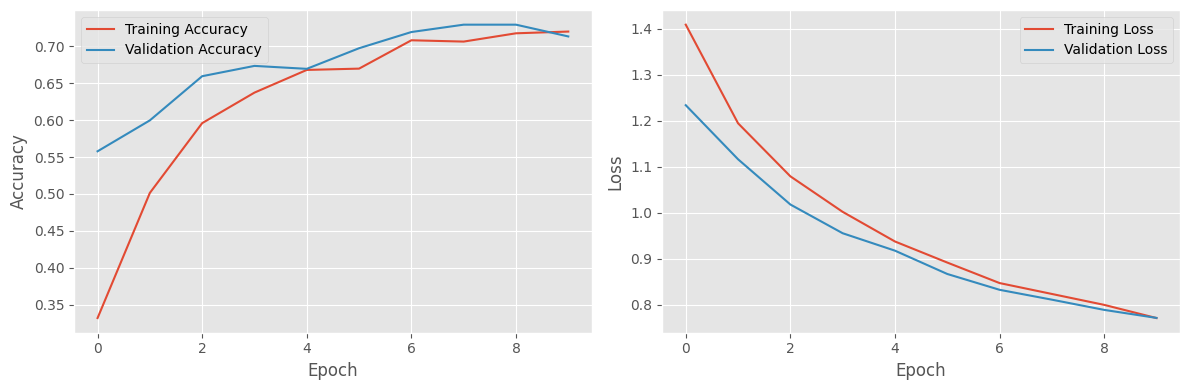

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 184ms/step - accuracy: 0.7070 - loss: 0.7416 - precision: 0.8514 - recall: 0.5417

Test accuracy: 0.7073
Test precision: 0.8456
Test recall: 0.5122
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 338ms/step


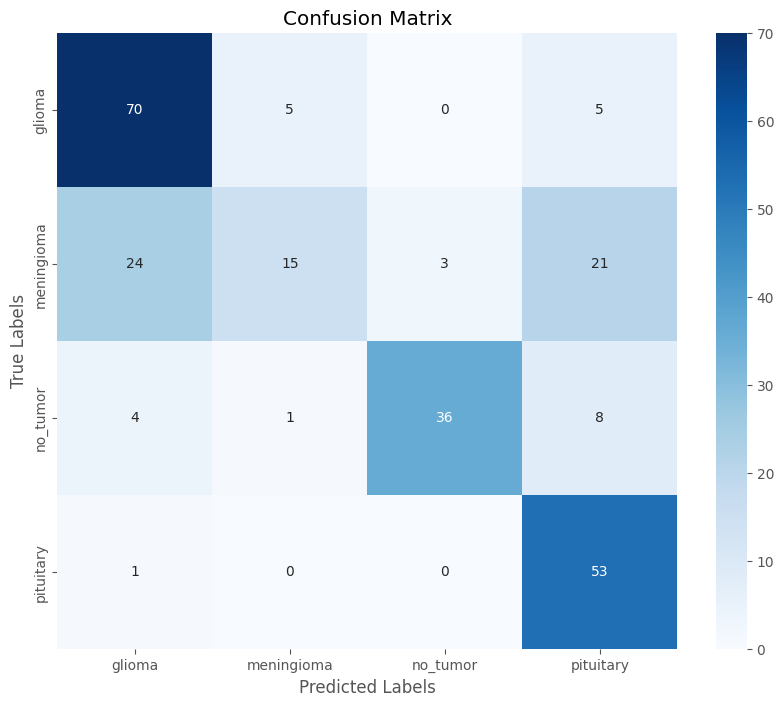

In [23]:
#training history and confusion matrix

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Plot training history
def plot_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(vgg_history)


# Evaluate on test set (assuming you have a test_generator)
test_generator.reset() # Reset the generator before evaluating
test_loss, test_acc, test_precision, test_recall = vgg_model.evaluate(test_generator)
print(f'\nTest accuracy: {test_acc:.4f}')
print(f'Test precision: {test_precision:.4f}')
print(f'Test recall: {test_recall:.4f}')


# Generate predictions
predictions = vgg_model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Get true classes
true_classes = test_generator.classes

# Confusion Matrix
conf_mat = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# **ResNet50 Evaluation**

In [24]:
def evaluate_resnet50():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False

    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = tf.keras.applications.resnet50.preprocess_input(inputs)
    x = base_model(x, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.2)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(0.001),
                 loss='categorical_crossentropy',
                 metrics=['accuracy', 'precision', 'recall'])

    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=10,
        callbacks=[EarlyStopping(patience=3)]
    )

    return model, history

In [25]:
resnet_model, resnet_history = evaluate_resnet50()
model_comparison.append({
    'Model': 'ResNet50',
    'Val Accuracy': max(resnet_history.history['val_accuracy']),
    'Val Precision': max(resnet_history.history['val_precision']),
    'Val Recall': max(resnet_history.history['val_recall']),
    'Parameters': f"{resnet_model.count_params():,}",
    'Inference Time': 'Medium',
    'Best For': 'General purpose'
})

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.3019 - loss: 1.4436 - precision: 0.3669 - recall: 0.0434 - val_accuracy: 0.4442 - val_loss: 1.2568 - val_precision: 0.7931 - val_recall: 0.0458
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 58s 643ms/step - accuracy: 0.4199 - loss: 1.2725 - precision: 0.6876 - recall: 0.0849 - val_accuracy: 0.4781 - val_loss: 1.1950 - val_precision: 0.8000 - val_recall: 0.0478
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 32s 612ms/step - accuracy: 0.4732 - loss: 1.2167 - precision: 0.7283 - recall: 0.0870 - val_accuracy: 0.5219 - val_loss: 1.1562 - val_precision: 0.8409 - val_recall: 0.0737
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 32s 612ms/step - accuracy: 0.4830 - loss: 1.1944 - precision: 0.7304 - recall: 0.1125 - val_accuracy: 0.5916 - val_loss: 1.1308 - val_precision: 0.8636 - val_recall: 0.0757
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 32s 611ms/step - accuracy: 0.5127 - loss: 1.1588 - precision: 0.7273 -

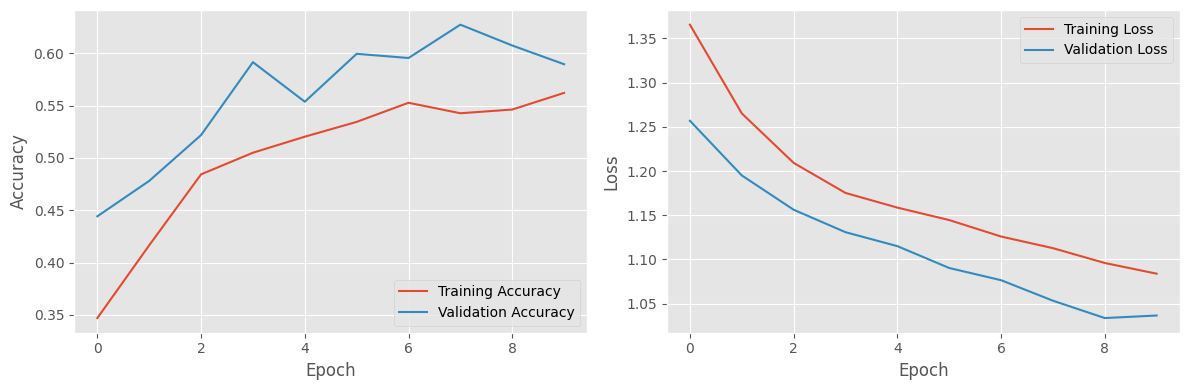

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 170ms/step - accuracy: 0.6529 - loss: 0.9847 - precision: 0.7592 - recall: 0.3859

Test accuracy: 0.5854
Test precision: 0.6983
Test recall: 0.3293


8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 778ms/step


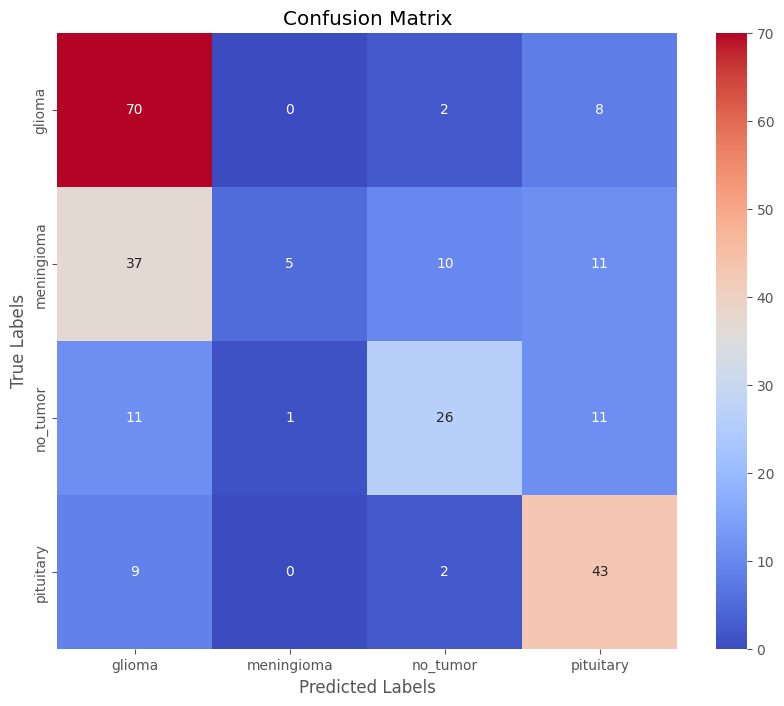

In [26]:
#training history and confusion matrix

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Plot training history
def plot_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(resnet_history)


# Evaluate on test set (assuming you have a test_generator)
test_generator.reset() # Reset the generator before evaluating
test_loss, test_acc, test_precision, test_recall = resnet_model.evaluate(test_generator)
print(f'\nTest accuracy: {test_acc:.4f}')
print(f'Test precision: {test_precision:.4f}')
print(f'Test recall: {test_recall:.4f}')


# Generate predictions
predictions = resnet_model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Get true classes
true_classes = test_generator.classes

# Confusion Matrix
conf_mat = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='coolwarm',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# **MobileNet Evaluation**

In [27]:
def evaluate_mobilenet():
    base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False

    model = tf.keras.Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(0.001),
                 loss='categorical_crossentropy',
                 metrics=['accuracy', 'precision', 'recall'])

    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=10,
        callbacks=[EarlyStopping(patience=3)]
    )

    return model, history

In [28]:
mobilenet_model, mobilenet_history = evaluate_mobilenet()
model_comparison.append({
    'Model': 'MobileNet',
    'Val Accuracy': max(mobilenet_history.history['val_accuracy']),
    'Val Precision': max(mobilenet_history.history['val_precision']),
    'Val Recall': max(mobilenet_history.history['val_recall']),
    'Parameters': f"{mobilenet_model.count_params():,}",
    'Inference Time': 'Fast',
    'Best For': 'Mobile/Edge devices'
})

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.4466 - loss: 1.4472 - precision: 0.4899 - recall: 0.3303 - val_accuracy: 0.7629 - val_loss: 0.6060 - val_precision: 0.8175 - val_recall: 0.6693
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 32s 596ms/step - accuracy: 0.7413 - loss: 0.6442 - precision: 0.8033 - recall: 0.6757 - val_accuracy: 0.8307 - val_loss: 0.4485 - val_precision: 0.8764 - val_recall: 0.7769
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 39s 734ms/step - accuracy: 0.8176 - loss: 0.4725 - precision: 0.8584 - recall: 0.7712 - val_accuracy: 0.8546 - val_loss: 0.4061 - val_precision: 0.8838 - val_recall: 0.8028
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 619ms/step - accuracy: 0.8580 - loss: 0.4015 - precision: 0.8897 - recall: 0.8118 - val_accuracy: 0.8446 - val_loss: 0.4083 - val_precision: 0.8750 - val_recall: 0.8088
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 35s 663ms/step - accuracy: 0.8751 - loss: 0.3424 - precision: 0.8961 -

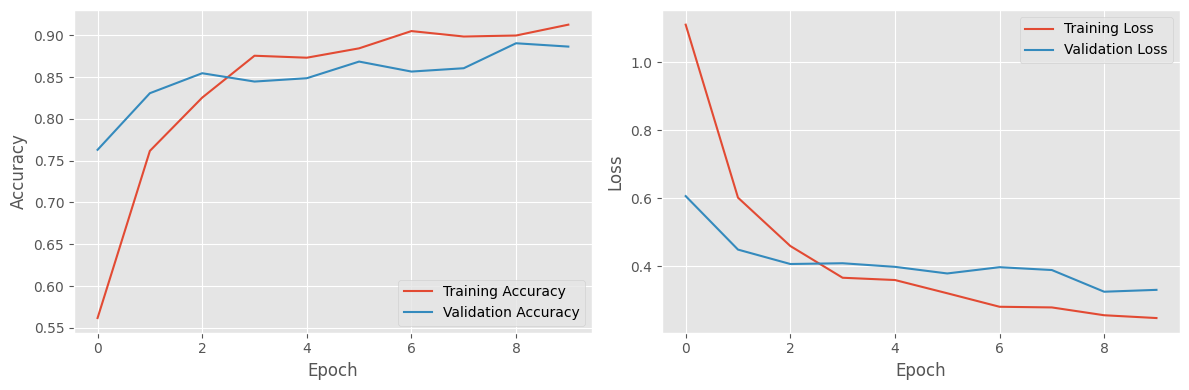

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step - accuracy: 0.8727 - loss: 0.2878 - precision: 0.8731 - recall: 0.8565

MobileNet Test accuracy: 0.8618
MobileNet Test precision: 0.8619
MobileNet Test recall: 0.8374


8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 593ms/step


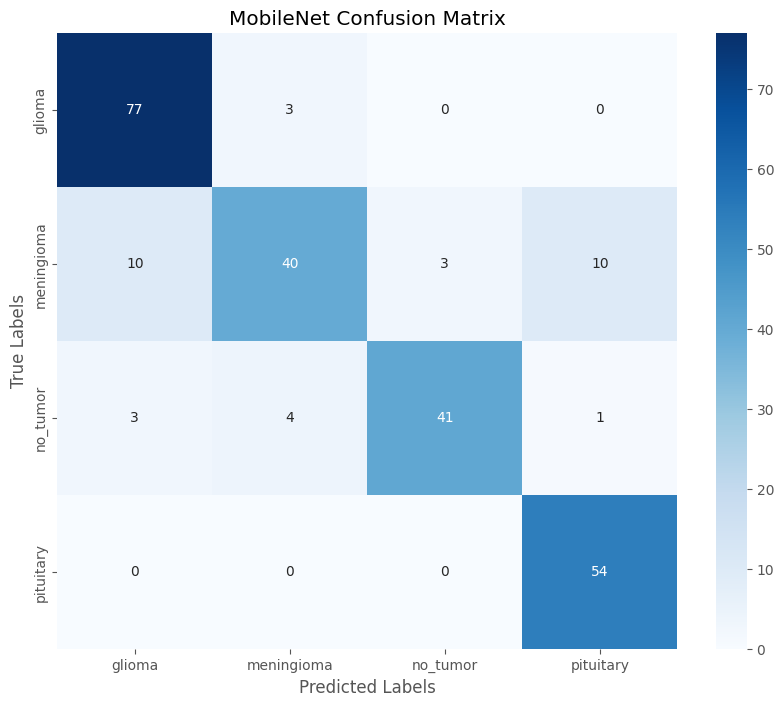

In [29]:
# Plot training history for MobileNet
plot_history(mobilenet_history)

# Evaluate on test set for MobileNet
test_generator.reset()  # Reset the generator before evaluating
test_loss, test_acc, test_precision, test_recall = mobilenet_model.evaluate(test_generator)
print(f'\nMobileNet Test accuracy: {test_acc:.4f}')
print(f'MobileNet Test precision: {test_precision:.4f}')
print(f'MobileNet Test recall: {test_recall:.4f}')

# Generate predictions for MobileNet
predictions = mobilenet_model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Get true classes for MobileNet
true_classes = test_generator.classes

# Confusion Matrix for MobileNet
conf_mat = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix for MobileNet using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('MobileNet Confusion Matrix')
plt.show()

# **InceptionV3 Evaluation**

In [30]:
def evaluate_inception():
    # Special generator for Inception's 299x299 input
    inception_train_gen = train_datagen.flow_from_directory(
        train_dir, target_size=(299, 299), batch_size=batch_size)
    inception_val_gen = val_datagen.flow_from_directory(
        val_dir, target_size=(299, 299), batch_size=batch_size)

    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
    base_model.trainable = False

    inputs = tf.keras.Input(shape=(299, 299, 3))
    x = tf.keras.applications.inception_v3.preprocess_input(inputs)
    x = base_model(x, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.2)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(0.001),
                 loss='categorical_crossentropy',
                 metrics=['accuracy', 'precision', 'recall'])

    history = model.fit(
        inception_train_gen,
        validation_data=inception_val_gen,
        epochs=10,
        callbacks=[EarlyStopping(patience=3)]
    )

    return model, history

In [31]:
inception_model, inception_history = evaluate_inception()
model_comparison.append({
    'Model': 'InceptionV3',
    'Val Accuracy': max(inception_history.history['val_accuracy']),
    'Val Precision': max(inception_history.history['val_precision']),
    'Val Recall': max(inception_history.history['val_recall']),
    'Parameters': f"{inception_model.count_params():,}",
    'Inference Time': 'Medium',
    'Best For': 'Multi-scale features'
})

Found 1695 images belonging to 4 classes.
Found 502 images belonging to 4 classes.
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.2843 - loss: 1.4004 - precision: 0.3665 - recall: 0.0446 - val_accuracy: 0.5677 - val_loss: 1.1621 - val_precision: 0.6818 - val_recall: 0.0896
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.5069 - loss: 1.1775 - precision: 0.7468 - recall: 0.1698 - val_accuracy: 0.5359 - val_loss: 1.0875 - val_precision: 0.7687 - val_recall: 0.2052
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 48s 908ms/step - accuracy: 0.5278 - loss: 1.1386 - precision: 0.7564 - recall: 0.2003 - val_accuracy: 0.6195 - val_loss: 1.0158 - val_precision: 0.8098 - val_recall: 0.2968
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 47s 890ms/step - accuracy: 0.5785 - loss: 1.0694 - precision: 0.7772 - recall: 0.2301 - val_accuracy: 0.6474 - val_loss: 0.9810 - val_precision: 0.7906 - val_recall: 0.3008
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 49s 932ms/step - accuracy: 0.6115 - loss: 1.0194 - precision: 0.7755 - recall: 0.2911 - val_accuracy: 0.6275 - val_loss: 0.

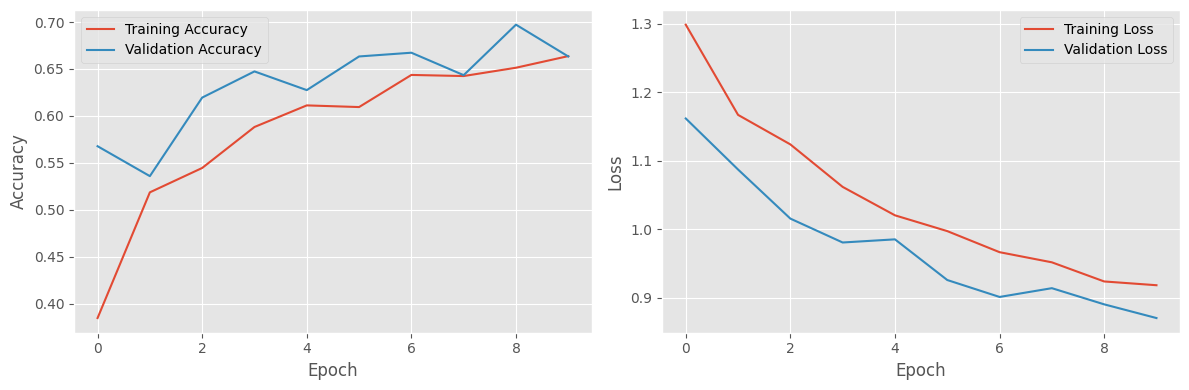

Found 246 images belonging to 4 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 192ms/step - accuracy: 0.6772 - loss: 0.8683 - precision: 0.7449 - recall: 0.4874

Test accuracy: 0.6545
Test precision: 0.7425
Test recall: 0.5041
8/8 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step


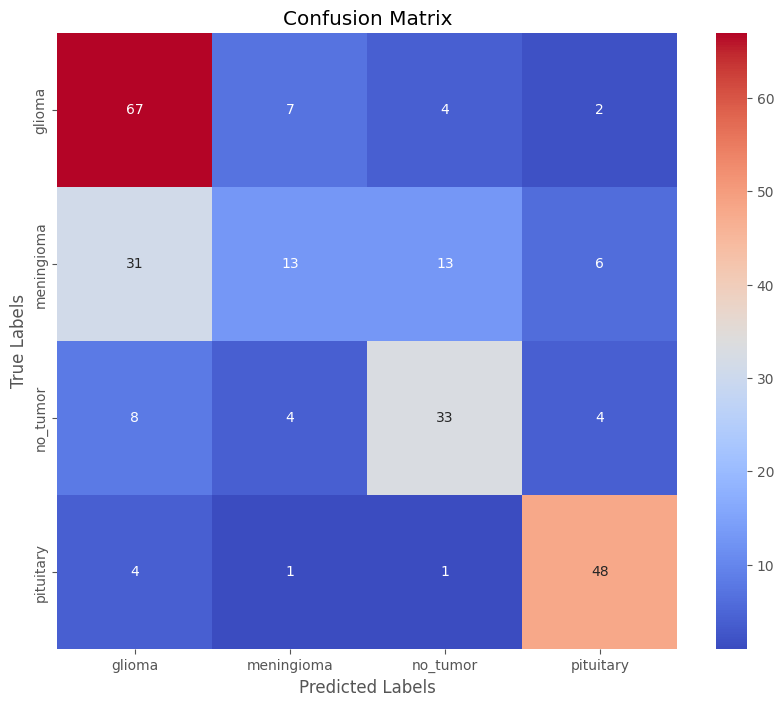

In [33]:
#training history and confusion matrix

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Plot training history
def plot_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(inception_history)

# Create a test generator specifically for InceptionV3 with target size (299, 299)
inception_test_gen = val_datagen.flow_from_directory(
    test_dir,
    target_size=(299, 299),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Important for evaluating the test set
)


# Evaluate on test set (assuming you have a test_generator)
inception_test_gen.reset() # Reset the generator before evaluating
test_loss, test_acc, test_precision, test_recall = inception_model.evaluate(inception_test_gen)
print(f'\nTest accuracy: {test_acc:.4f}')
print(f'Test precision: {test_precision:.4f}')
print(f'Test recall: {test_recall:.4f}')


# Generate predictions
predictions = inception_model.predict(inception_test_gen)
predicted_classes = np.argmax(predictions, axis=1)

# Get true classes
true_classes = inception_test_gen.classes

# Confusion Matrix
conf_mat = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='coolwarm',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# **EfficientNetB0 Evaluation**

In [34]:
def evaluate_efficientnet():
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False

    model = tf.keras.Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(0.001),
                 loss='categorical_crossentropy',
                 metrics=['accuracy', 'precision', 'recall'])

    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=10,
        callbacks=[EarlyStopping(patience=3)]
    )

    return model, history

In [37]:
efficientnet_model, efficientnet_history = evaluate_efficientnet()
model_comparison.append({
    'Model': 'EfficientNetB0',
    'Val Accuracy': max(efficientnet_history.history['val_accuracy']),
    'Val Precision': max(efficientnet_history.history['val_precision']),
    'Val Recall': max(efficientnet_history.history['val_recall']),
    'Parameters': f"{efficientnet_model.count_params():,}",
    'Inference Time': 'Fast',
    'Best For': 'Best accuracy/efficiency tradeoff'
})

Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 70s 949ms/step - accuracy: 0.3019 - loss: 1.3965 - precision: 0.2338 - recall: 0.0055 - val_accuracy: 0.2351 - val_loss: 1.3812 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 32s 606ms/step - accuracy: 0.2926 - loss: 1.3992 - precision: 0.2963 - recall: 2.0142e-04 - val_accuracy: 0.3207 - val_loss: 1.3754 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 29s 557ms/step - accuracy: 0.3250 - loss: 1.3766 - precision: 0.2652 - recall: 0.0012 - val_accuracy: 0.2351 - val_loss: 1.3934 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 30s 559ms/step - accuracy: 0.2884 - loss: 1.3803 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.3207 - val_loss: 1.3757 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 30s 565ms/step - accuracy: 0.3138 - loss: 1.3796 - precision: 0.4186 - rec

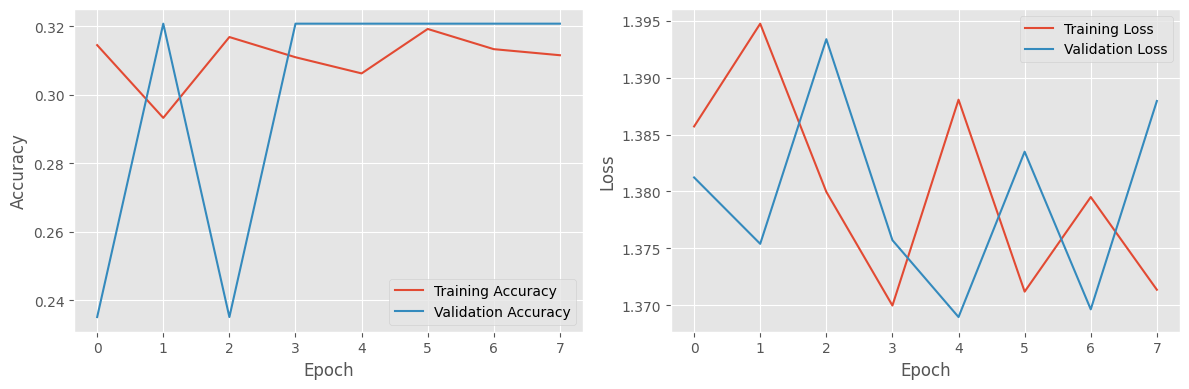

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step - accuracy: 0.5981 - loss: 1.3075 - precision: 0.0000e+00 - recall: 0.0000e+00

Test accuracy: 0.3252
Test precision: 0.0000
Test recall: 0.0000
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step


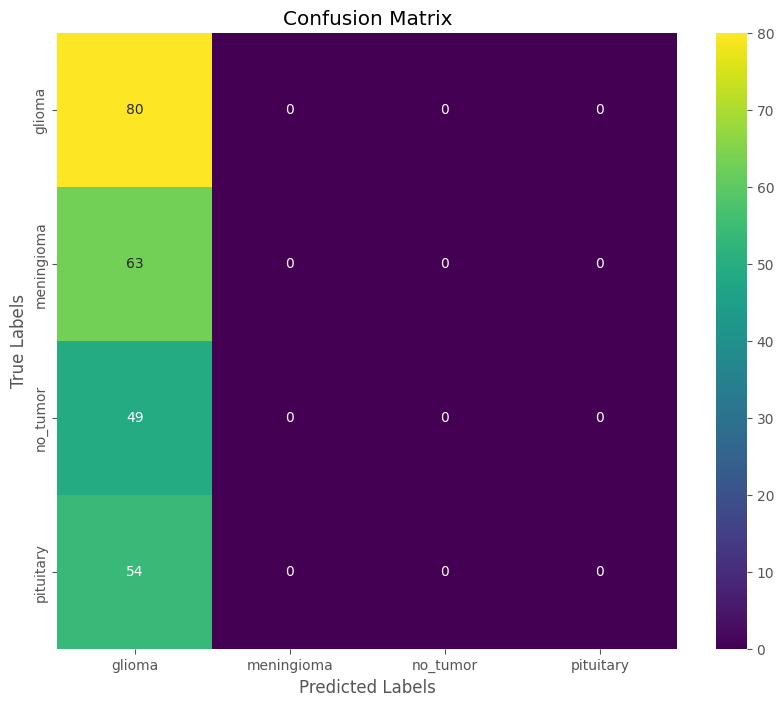

In [38]:
#training history and confusion matrix

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Plot training history
def plot_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(efficientnet_history)


# Evaluate on test set (assuming you have a test_generator)
test_generator.reset() # Reset the generator before evaluating
test_loss, test_acc, test_precision, test_recall = efficientnet_model.evaluate(test_generator)
print(f'\nTest accuracy: {test_acc:.4f}')
print(f'Test precision: {test_precision:.4f}')
print(f'Test recall: {test_recall:.4f}')


# Generate predictions
predictions = efficientnet_model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Get true classes
true_classes = test_generator.classes

# Confusion Matrix
conf_mat = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='viridis',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# **Results Comparison**

In [39]:
comparison_df = pd.DataFrame(model_comparison)
comparison_df = comparison_df.sort_values('Val Accuracy', ascending=False)
comparison_df.style.background_gradient(cmap='Blues', subset=['Val Accuracy', 'Val Precision', 'Val Recall'])

,Model,Val Accuracy,Val Precision,Val Recall,Parameters,Inference Time,Best For
2,MobileNet,0.890438,0.907025,0.878486,"3,232,964",Fast,Mobile/Edge devices
0,VGG16,0.729084,0.897727,0.519920,"14,716,740",Medium,Medium-sized datasets
3,InceptionV3,0.697211,0.809783,0.498008,"21,810,980",Medium,Multi-scale features
1,ResNet50,0.627490,0.863636,0.356574,"23,595,908",Medium,General purpose
4,EfficientNetB0,0.320717,0.000000,0.000000,"4,054,695",Fast,Best accuracy/efficiency tradeoff
5,EfficientNetB0,0.320717,0.000000,0.000000,"4,054,695",Fast,Best accuracy/efficiency tradeoff


In [40]:
# Save the DataFrame to a CSV file
comparison_df.to_csv('/content/Vasanth_P/MyDrive/Project_4_Brain_Tumor_MRI_Image_Classification/dataset/model_comparison.csv', index=False)

In [41]:
import pandas as pd
df=pd.read_csv('/content/Vasanth_P/MyDrive/Project_4_Brain_Tumor_MRI_Image_Classification/dataset/model_comparison.csv')
df

,Model,Val Accuracy,Val Precision,Val Recall,Parameters,Inference Time,Best For
0,MobileNet,0.890438,0.907025,0.878486,"3,232,964",Fast,Mobile/Edge devices
1,VGG16,0.729084,0.897727,0.519920,"14,716,740",Medium,Medium-sized datasets
2,InceptionV3,0.697211,0.809783,0.498008,"21,810,980",Medium,Multi-scale features
3,ResNet50,0.627490,0.863636,0.356574,"23,595,908",Medium,General purpose
4,EfficientNetB0,0.320717,0.000000,0.000000,"4,054,695",Fast,Best accuracy/efficiency tradeoff
5,EfficientNetB0,0.320717,0.000000,0.000000,"4,054,695",Fast,Best accuracy/efficiency tradeoff


The best performing model is:
Model                       MobileNet
Val Accuracy                 0.890438
Val Precision                0.907025
Val Recall                   0.878486
Parameters                  3,232,964
Inference Time                   Fast
Best For          Mobile/Edge devices
Name: 0, dtype: object


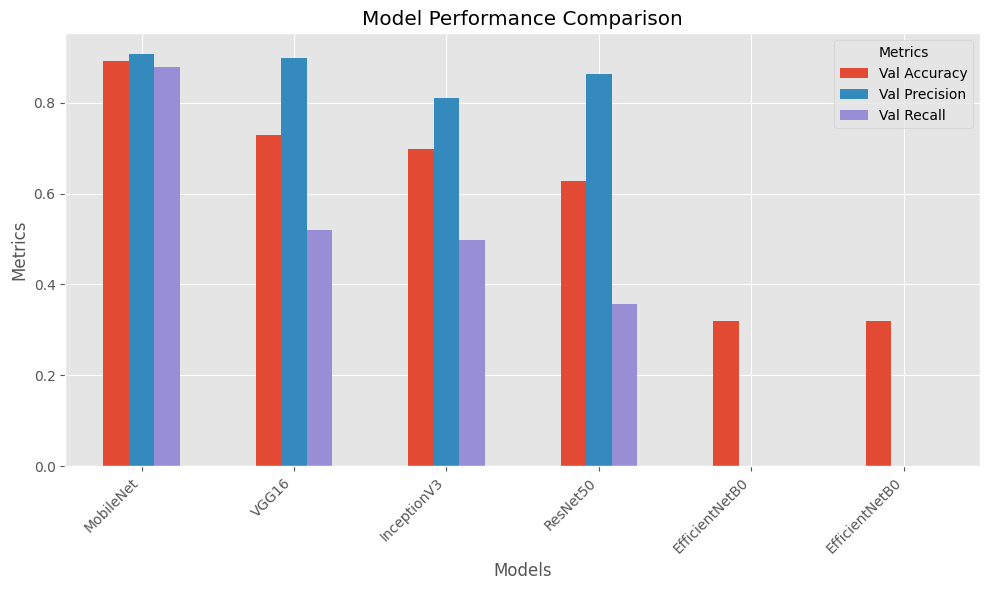

In [42]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('/content/Vasanth_P/MyDrive/Project_4_Brain_Tumor_MRI_Image_Classification/dataset/model_comparison.csv')


# Find the best model based on validation accuracy
best_model = df.loc[df['Val Accuracy'].idxmax()]

print(f"The best performing model is:\n{best_model}")

# Plotting the bar chart
plt.figure(figsize=(10, 6))
df.plot(x='Model', y=['Val Accuracy', 'Val Precision', 'Val Recall'], kind='bar', ax=plt.gca())
plt.title('Model Performance Comparison')
plt.ylabel('Metrics')
plt.xlabel('Models')


plt.xticks(rotation=45, ha='right')
plt.legend(title='Metrics')
plt.tight_layout()
plt.show()

In [43]:

# save the model

mobilenet_model.save('/content/Vasanth_P/MyDrive/Project_4_Brain_Tumor_MRI_Image_Classification/dataset/mobilenet_model.h5')